In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
plt.style.use('informes.mplstyle')

In [94]:
df = pd.read_csv(r'Mediciones\Clase 3\PID\PID-2-0.07-2-barrido.csv')

t = df['Time'].values
h = df['Position'].values
I = df['I'].values
P = df['P'].values
D = df['D'].values

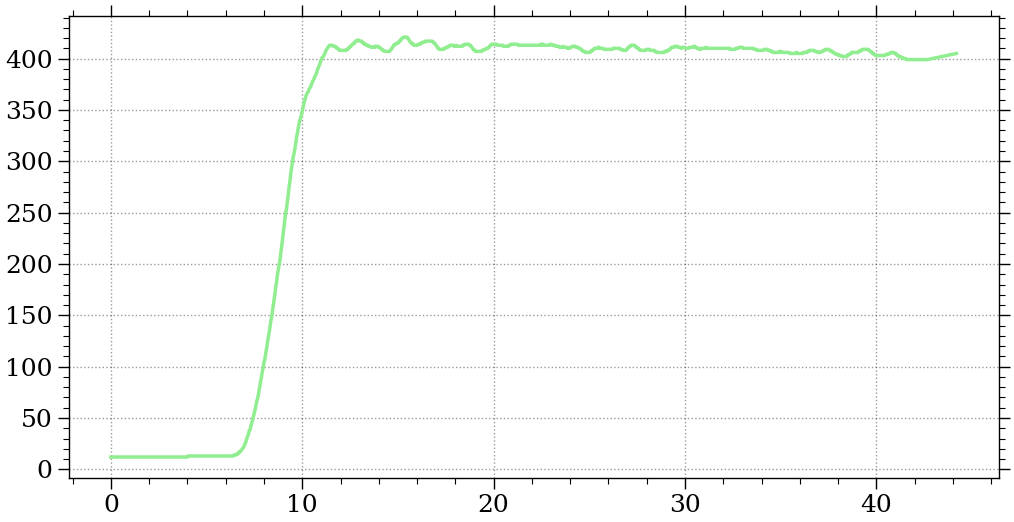

In [4]:
fig, ax = plt.subplots()

ax.plot(t,h)

FILTRO IIR (Infinite Impulse Response)

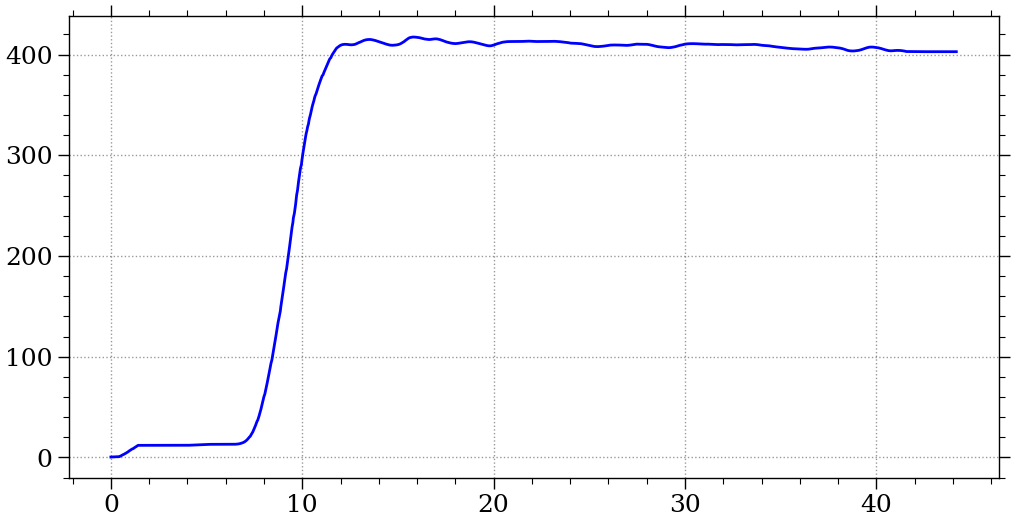

In [5]:
from scipy.signal import lfilter 

n = 30
b = [1.0 / n] * n
a = 1
hh = lfilter(b, a, h)
plt.plot(t, hh, linewidth=2, linestyle="-", c="b")  # smooth by filter

FILTRO PASA ALTOS

In [70]:
from scipy.signal import butter,filtfilt
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype = "high", analog = False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

27


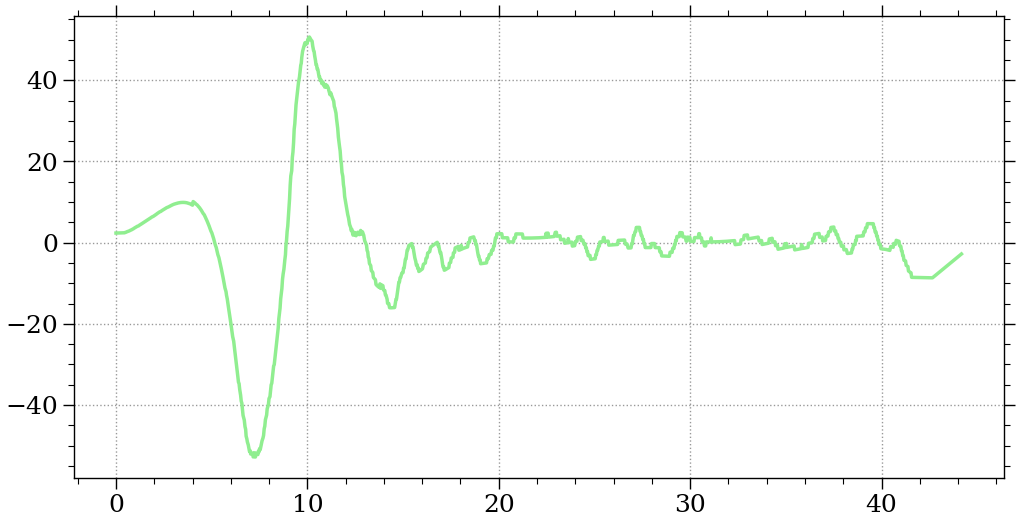

In [100]:
fs = int(len(t)/t[-1])
print(fs)
highpass_h = butter_highpass_filter(h,0.1,fs,2)
fig, ax = plt.subplots()
ax.plot(t,highpass_h)

Text(0.5, 1.0, 'Posición - posición filtrada (no pasa altos)')

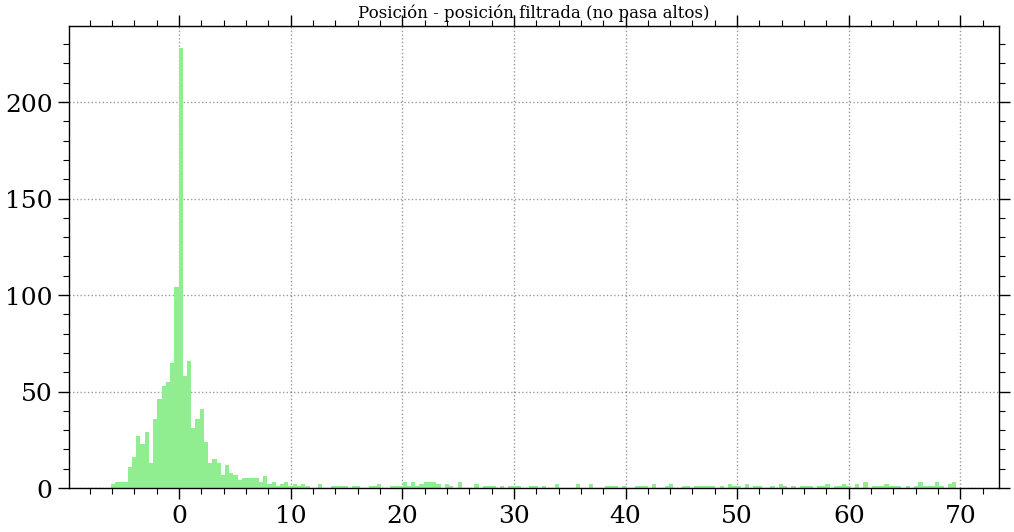

In [98]:
fig, ax = plt.subplots()
noise = h-hh
ax.hist(noise,bins=200)
plt.title(f'Posición - posición filtrada (no pasa altos)')

Text(0.5, 1.0, 'h filtrado pasa alto')

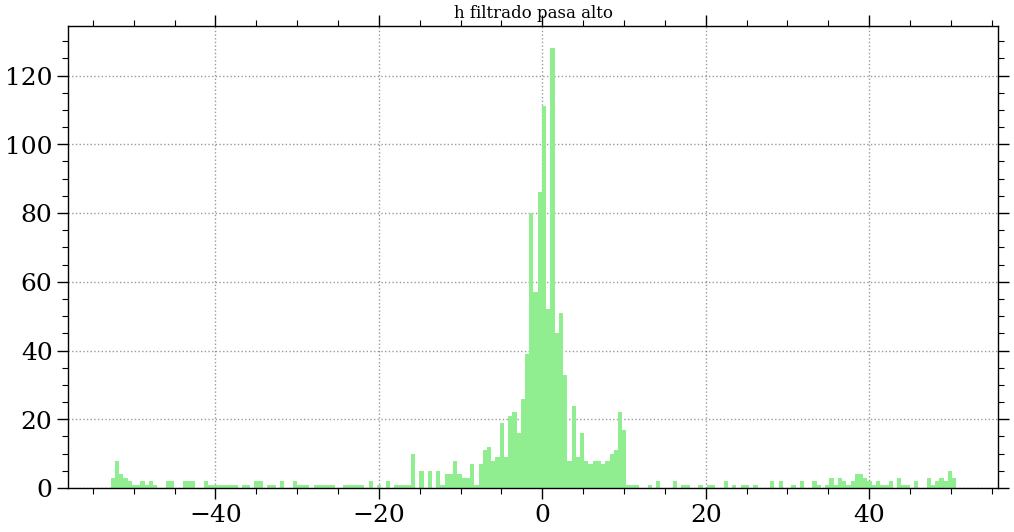

In [101]:
fig, ax = plt.subplots()
noise = highpass_h
ax.hist(noise,bins=200)
plt.title(f'h filtrado pasa alto')

Text(0, 0.5, 'FFT Amplitude |X(freq)|')

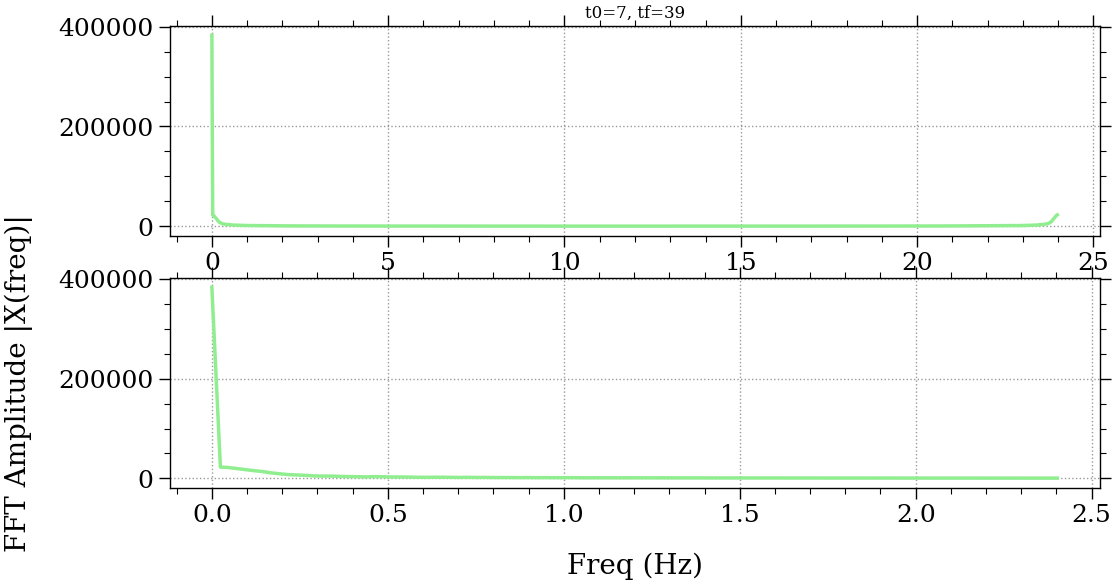

In [112]:
from scipy.fft import fft, ifft, fftfreq

fig, ax = plt.subplots(2,1)

hf = fft(h)
sampling_interval = t[-1]/len(t)
sr = int(1/sampling_interval)
N = len(hf)
n = np.arange(N)
T = N/sr
freq = n/T
ax[0].set_title(f't0={int(t[0])}, tf={int(t[-1])}')
ax[0].plot(freq,np.abs(hf))
ax[1].plot(freq[:100],np.abs(hf[:100]))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
# frequencies = fftfreq(len(h),samplerate)[0:N//2]

# hf_plot = 2/N*np.abs(hf)[:N//2]
# test = hf_plot[:100]
# plt.plot(frequencies,hf_plot)
# plt.xlim(0.1,.4)
# plt.ylim(0,40)

Text(0, 0.5, 'FFT Amplitude |X(freq)|')

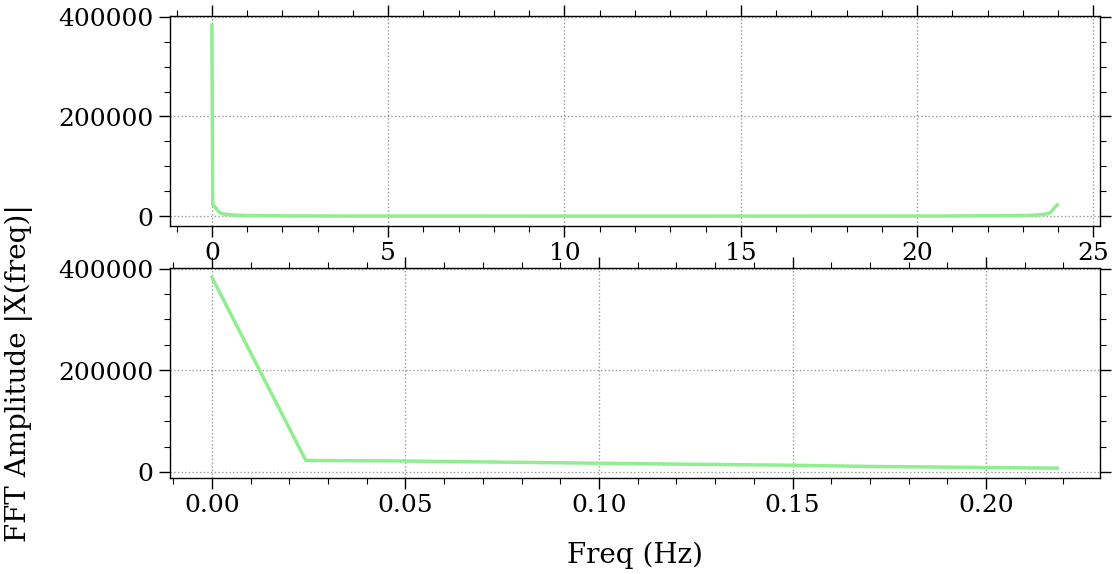

In [106]:
df = pd.read_csv(r'Mediciones\Clase 3\PID\PID-2-0.07-2-barrido.csv')
df = df[(df['Time'] > 7) & (df['Time'] < 40)]
t = df['Time'].values
h = df['Position'].values
I = df['I'].values
P = df['P'].values
D = df['D'].values

from scipy.fft import fft, ifft, fftfreq

fig, ax = plt.subplots(2,1)

hf = fft(h)
sampling_interval = t[-1]/len(t)
sr = int(1/sampling_interval)
N = len(hf)
n = np.arange(N)
T = N/sr
freq = n/T
ax[0].plot(freq,np.abs(hf))
ax[1].plot(freq[:10],np.abs(hf[:10]))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')


24


Text(0.5, 1.0, 'Posición filtrada pasa altos')

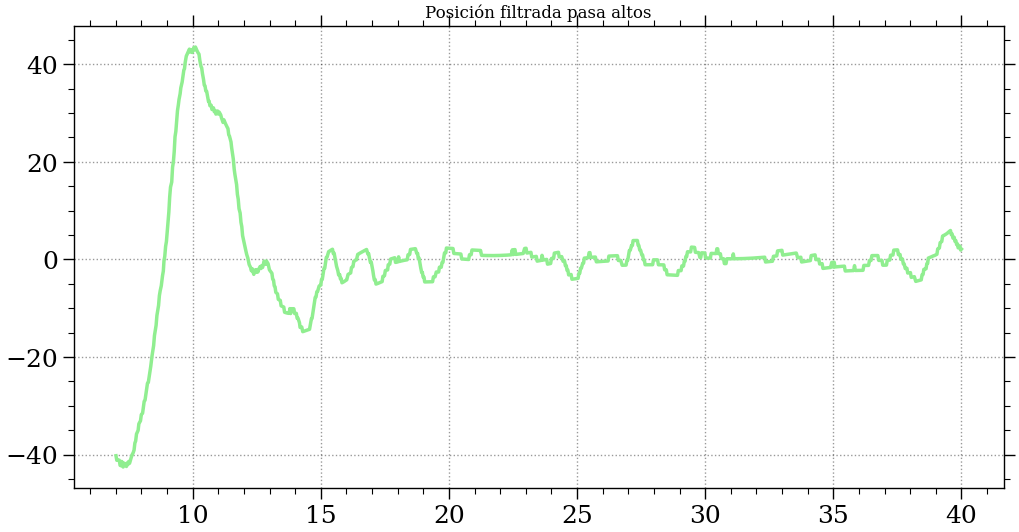

In [134]:
fs = int(len(t)/t[-1])
print(fs)
highpass_h = butter_highpass_filter(h,0.1,fs,2)
fig, ax = plt.subplots()
ax.plot(t,highpass_h)
ax.set_title(f'Posición filtrada pasa altos')

[0.02290014 0.02293041 0.02296065 0.02299088 0.02302109 0.02305127
 0.02308144 0.02311158 0.0231417  0.0231718  0.02320188 0.02323194
 0.02326197 0.02329198 0.02332197 0.02335194 0.02338188 0.0234118
 0.0234417  0.02347157 0.02350143 0.02353125 0.02356105 0.02359083
 0.02362059 0.02365031 0.02368002 0.0237097  0.02373935 0.02376898
 0.02379858 0.02382816 0.02385771 0.02388724 0.02391674 0.02394621
 0.02397566 0.02400508 0.02403447 0.02406383 0.02409317 0.02412248
 0.02415176 0.02418102 0.02421024 0.02423944 0.02426861 0.02429775
 0.02432686 0.02435595 0.024385   0.02441402 0.02444302 0.02447198
 0.02450092 0.02452982 0.02455869 0.02458754 0.02461635 0.02464513
 0.02467388 0.0247026  0.02473129 0.02475994 0.02478856 0.02481716
 0.02484572 0.02487424 0.02490274 0.0249312  0.02495963 0.02498802
 0.02501638 0.02504471 0.025073   0.02510126 0.02512949 0.02515768
 0.02518584 0.02521396 0.02524205 0.0252701  0.02529812 0.0253261
 0.02535405 0.02538196 0.02540983 0.02543767 0.02546547 0.025493

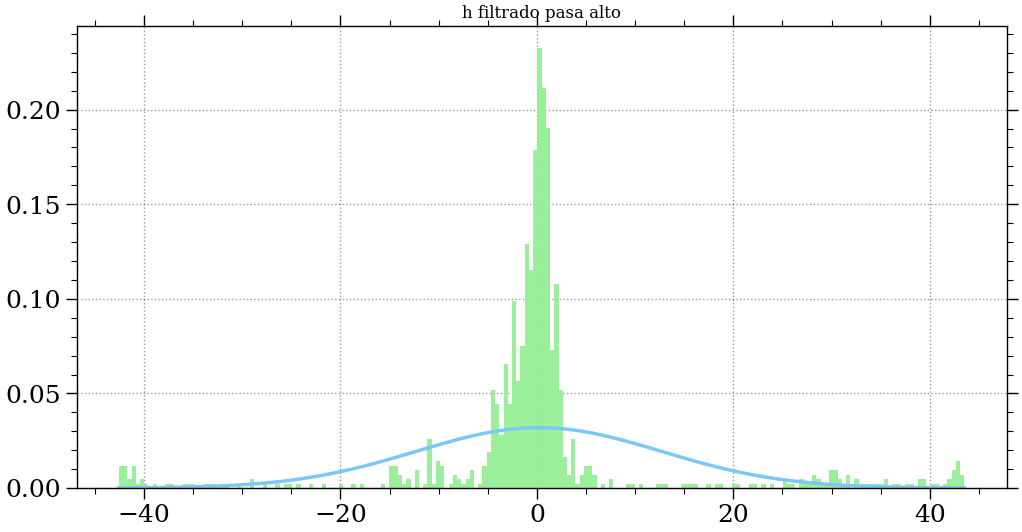

In [146]:
import statistics
from scipy.stats import norm

fig, ax = plt.subplots()
noise = highpass_h
mu, sigma = norm.fit(noise)
# noise = [element for element in noise if (element > -15 and element < 15)]

_, bins, _ = plt.hist(noise, 200, density=True, alpha=0.9)
# ax.hist(noise,bins=200)
# xmin,xmax = min(noise),max(noise)
xmin,xmax = -10,10

best_fit_line = norm.pdf(bins, mu, sigma)

x = np.linspace(xmin,xmax,len(noise))
p = norm.pdf(x, mu, sigma)

ax.plot(bins, best_fit_line)
plt.title(f'h filtrado pasa alto')
# ax.plot(x,p)
print(p)

989
989
<class 'numpy.float64'>


ValueError: `sigma` has incorrect shape.

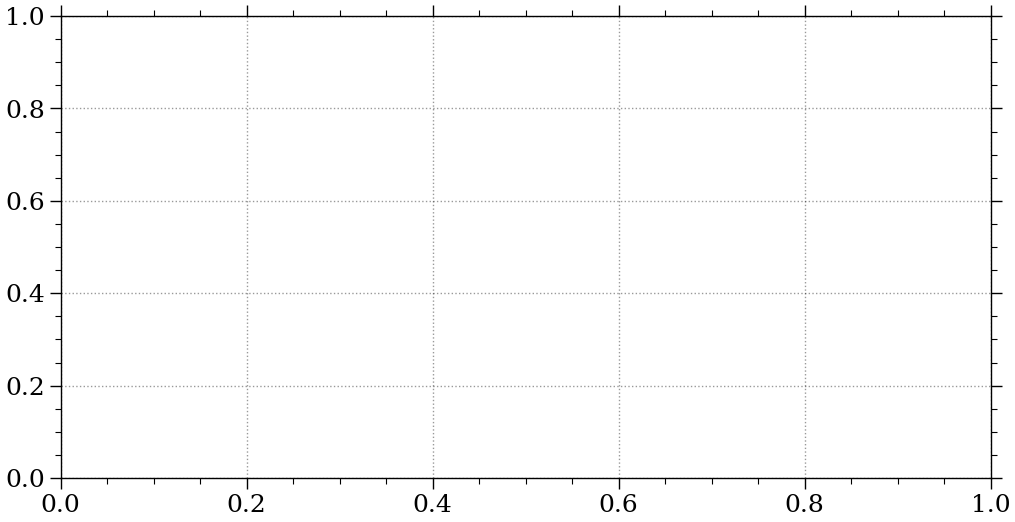

In [149]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as mpl
  
# Let's create a function to model and create data
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
  
fig, ax = plt.subplots()
print(len(x))
print(len(noise))
sigma = np.sum(noise**2)/len(noise)
print(type(sigma))
# Executing curve_fit on noisy data
popt, pcov = curve_fit(func, x, noise,0,sigma)
  
#popt returns the best fit values for parameters of the given model (func)
print (popt)
  
ym = func(x, popt[0], popt[1], popt[2])
ax.plot(x, ym, c='r', label='Best fit')
ax.legend()